# Notebook settings

## Notebook magic

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload

## Import libraries

In [948]:
import numpy
import pylab
import scipy.sparse
import h5py
import scipy.stats
import copy
import biom
import sklearn
from numba import jit,prange
import random
import pickle
import scipy
import numpy as np
import seaborn as sns
import pandas as pd
import sklearn.metrics
import warnings
import matplotlib.pyplot as plt
from biom import load_table
from pylab import figure, cm
from matplotlib.colors import LogNorm
import geopy.distance
import sklearn.manifold
import matplotlib.lines as mlines


In [3]:
warnings.filterwarnings('ignore')

# Functions

In [929]:
def group_by_param(parameter, value,
                   n_points = None, nbins = 20, binby = 'n_points'):
    samples2plot = map_file_soil[map_file_soil[parameter] == value].index
    dist_frame2plot = copy.deepcopy(
        dist_frame[((dist_frame.sample1.isin(samples2plot))&
                  (dist_frame.sample2.isin(samples2plot)))]
    )
    if binby == 'n_points':
        if not n_points:
            n_points = int(dist_frame2plot.shape[0]/20)
        ksort = np.argsort(dist_frame2plot.geo_distance.values)
        bins=dist_frame2plot.geo_distance.values[ksort[0::n_points]]
        bins=np.append(bins,dist_frame2plot.geo_distance.values[ksort[-1]])
    if binby == 'dist':
        _, bins = np.histogram(dist_frame2plot.geo_distance, nbins)

    dist_frame2plot['ind'] = np.digitize(dist_frame2plot.geo_distance.values, bins)
    dist_frame_grouped = dist_frame2plot.groupby(['ind'])['geo_distance', 
                                                          'similarity'].agg(['mean', 
                                                                             'std',
                                                                            'count'])
    return n_points, dist_frame_grouped

def plot_sim_vs_dist(ax, dist_frame_grouped, color, label,plot=True,fit=True):

    fitfunc = lambda x, a, b, c: a * np.exp(-b * x) + c
    p0 = [0.4, 0.001, 0.4]
    popt, pcov = scipy.optimize.curve_fit(fitfunc, 
                                        dist_frame_grouped.geo_distance['mean'], 
                                        dist_frame_grouped.similarity['mean'], p0,
                                        bounds=([0.2, 0, 0], [0.6, 0.0015, np.inf]))


    if plot == True:
        ax.errorbar(dist_frame_grouped.geo_distance['mean'],
            dist_frame_grouped.similarity['mean'],
            xerr = dist_frame_grouped.geo_distance['std'],
            yerr = dist_frame_grouped.similarity['std'],
            fmt='o', ecolor=color, capthick=2, 
            capsize = 2,
            color = color,
            label = label,
            alpha = 0.5)
    if fit == True:
        ax.plot(dist_frame_grouped.geo_distance['mean'].values,
             fitfunc(dist_frame_grouped.geo_distance['mean'].values, *popt), '--', 
             color = color, lw = 4)

[Jensen-Shannon divergence](https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence) is calculated as $JSD(P||Q) = 1/2\cdot D(P||M) + 1/2\cdot D(Q||M)$, where $M = 1/2(P+Q)$ and $D(P||M) = \sum_i P_i \log\frac{P_i}{M_i}$.

In [775]:
#Non numba function, very inefficient
def JSD(P, Q):

    M = 0.5 * (P + Q)
    return 0.5 * (scipy.stats.entropy(P, M) + scipy.stats.entropy(Q, M))

In [776]:
#Numba function
@jit(parallel=True,nogil=True)
def JSD_numba_m(M, JSD):
    m,n = M.shape #m-number of samples, n-number of features
    for j in prange(0,m):
        for i in prange(0,j):
            for k in prange(n):
                if M[i,k] >0:
                    JSD[i,j] += 0.5 * M[i,k]*(np.log(M[i,k]/(0.5*M[i,k] + 0.5*M[j,k])))
                if M[j,k] >0:    
                    JSD[i,j] += 0.5 * M[j,k]*(np.log(M[j,k]/(0.5*M[i,k] + 0.5*M[j,k])))

    JSD += JSD.T
    
    
    return JSD

In [1173]:
#Calculate Jensen-Shannon divergence and save to file
def calc_JSD(OTU_table, sample_ids = None, filename=None, save = True, saveto = 'hdf5'):
    OTU_table_norm = OTU_table / OTU_table.sum(axis=1)[:,None]

    dist_matrix_JSD = JSD_numba_m(OTU_table_norm, 
                                  np.zeros((OTU_table_norm.shape[0],
                                           OTU_table_norm.shape[0]),dtype=np.float))
    if save == True:
        if saveto == hdf5:
            h5f = h5py.File(filename, 'w')
            h5f.create_dataset('distances', data=dist_matrix_JSD)
            h5f.create_dataset('sample_ids', data=np.array(pickle.dumps(sample_names)))
            h5f.close()
            del(h5f)
        if saveto == csv:
            dist_matrix_JSD.to_csv(dist_matrix_JSD, 
                                 columns=sample_ids, 
                                 index=sample_ids).to_csv(filename)
    return dist_matrix_JSD, OTU_table_norm

## Plotting options

In [429]:
def init_plotting_style(tick_font_size = 17, font_size = 17, 
                        lw = 2, mew = 0.5, markersize = 8, 
                        ticksize = 2, legendfontsize = 'small'):
  
  pylab.rc('xtick', labelsize=tick_font_size)
  pylab.rc('ytick', labelsize=tick_font_size) 
  pylab.rc('font', size=font_size) 
  pylab.rc('lines', lw = lw, mew = mew, markersize = markersize)
  pylab.rcParams['xtick.major.size'] = ticksize
  pylab.rcParams['ytick.major.size'] = ticksize
  pylab.rcParams['legend.fontsize'] = legendfontsize
  pylab.rcParams['axes.labelsize'] = tick_font_size

Read a table of xkcd colors

In [1449]:
colors = pd.read_table('../data/rgb.txt', skiprows=[0], 
                       header=None)

colors.drop(2, axis = 1, inplace = True)
colors.columns = ['color', 'code']

# Load and preprocess data

## Load metadata

Read map file.

In [872]:
root_folder = '/home/perlova/Work/2017.01.14-EMP/data/release1/'
map_file = pd.read_table(root_folder + 'mapping_files/emp_qiime_mapping_qc_filtered.tsv')

Select samples from soil.

In [873]:
map_file_soil = map_file[map_file['empo_3'] =='Soil (non-saline)']

Replace Nans in latitude and longitude with 0 for further calculations, round latitude and longitude to the 2 sig figs, and create a location column with longitude and latitude|.

In [874]:
map_file_soil.loc[np.isnan(map_file_soil.latitude_deg), 'latitude_deg'] = 0
map_file_soil.loc[np.isnan(map_file_soil.longitude_deg), 'longitude_deg'] = 0
map_file_soil.latitude_deg = map_file_soil.latitude_deg.apply(lambda x: round(x, 2))
map_file_soil.longitude_deg = map_file_soil.longitude_deg.apply(lambda x: round(x, 2))
map_file_soil['pos'] = list(zip(map_file_soil.latitude_deg, map_file_soil.longitude_deg))

Replace 'anthropogenic terrestrial biome' with envo_biome_3 categories (cropland and settlement)

In [1492]:
map_file_soil.loc[
    map_file_soil.envo_biome_2 == 'anthropogenic terrestrial biome', 
                     'envo_biome_2'] = map_file_soil[
    map_file_soil.envo_biome_2 == 'anthropogenic terrestrial biome'].envo_biome_3

Group samples by location and examine the number of samples from the same location.

In [875]:
loc_vs_n = map_file_soil.groupby(['pos', 'country'],as_index=False)['longitude_deg'].count()
loc_vs_n.columns = ['pos', 'country','number']
loc_vs_n.country = loc_vs_n.country.apply(lambda x: x[4:])

Text(0,0.5,'')

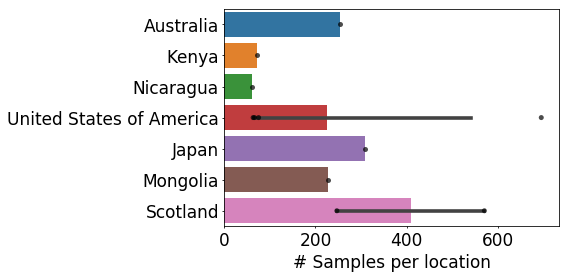

In [876]:
plt.figure(figsize=(6,4))
sns.barplot(y = 'country', x = 'number', data = loc_vs_n[loc_vs_n.number > 50], 
           )
sns.stripplot(y = 'country', x = 'number', data = loc_vs_n[loc_vs_n.number > 50], 
            color="k", alpha=.7)
plt.xlabel('# Samples per location')
plt.ylabel('')

Text(0.5,0,'# of species')

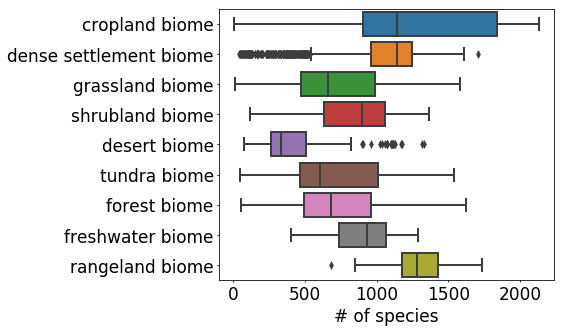

In [1493]:
plt.figure(figsize=(6, 5))
sns.boxplot(y = 'envo_biome_2', x = 'adiv_observed_otus', data = map_file_soil)
plt.ylabel('')
plt.xlabel('# of species')

## Load OTU tables.

In [877]:
otu_folder = 'otu_tables/deblur/'
filename = 'emp_deblur_90bp.qc_filtered_soil.biom'

Load biom tables as hdf5 and convert to dense from sparse matrix.

In [878]:
f=h5py.File(root_folder + otu_folder + filename)
OTUs = f['observation']['ids'][:]
samples = f['sample']['ids'][:]
mat = scipy.sparse.csr_matrix(
    (f['observation']['matrix']['data'][:],
     f['observation']['matrix']['indices'][:],
     f['observation']['matrix']['indptr'][:]),
    shape=f.attrs['shape'])

mat_dense=np.array(mat.todense()).T
f.close()
del(f)

Plot histogram of relative OTU abundances per sample.

In [879]:
mat_dense_norm = mat_dense / mat_dense.sum(axis=1)[:,None]

Text(0,0.5,'Count')

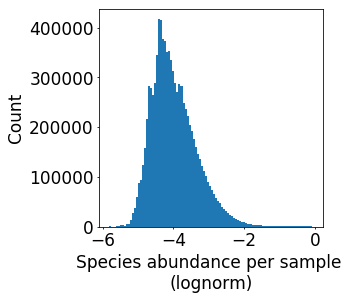

In [857]:
init_plotting_style(font_size=17)
plt.figure(figsize=(4,4))
_=plt.hist(np.log10(mat_dense_norm[mat_dense_norm!=0]), bins=100)
plt.xlabel('Species abundance per sample \n(lognorm)')
plt.ylabel('Count')

Look at how many bacterial species are observed in each samples.

Text(0,0.5,'# of samples')

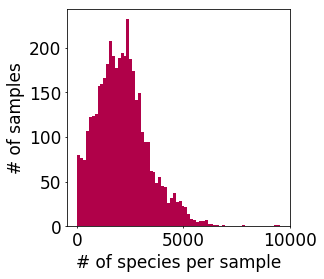

In [1101]:
counts = np.count_nonzero(mat_dense, axis = 1)

init_plotting_style(font_size=17)
plt.figure(figsize=(4,4))
_ = plt.hist(counts, bins = 70, lw = 2, 
             color = sns.xkcd_palette(['raspberry'])[0])
# plt.xlim(-10, 200)
# plt.axhline(1, lw = 1, color = 'k',ls = '--')
plt.xlabel('# of species per sample')
plt.ylabel('# of samples')

In how many samples each species is observed.

Text(0,0.5,'Fraction of species')

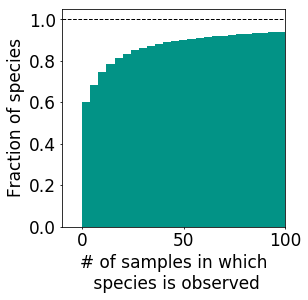

In [1112]:
counts = np.count_nonzero(mat_dense, axis = 0)

init_plotting_style(font_size=17)
plt.figure(figsize=(4,4))
_ = plt.hist(counts, bins = 1000, lw = 2, cumulative=True, normed = True,
             color = sns.xkcd_palette(['teal'])[0])
plt.xlim(-10, 100)
plt.axhline(1, lw = 1, color = 'k',ls = '--')
plt.xlabel('# of samples in which\n species is observed')
plt.ylabel('Fraction of species')

# Data analysis

Reorder mapping file according to the OTU table so it's consistent with mapping file.

In [887]:
map_file_soil.set_index('#SampleID', inplace=True)
map_file_soil = map_file_soil.loc[samples, :]

## Calculate pairwise distances between samples

Calculate pairwise distance matrix between samples and save to file, because it might take a while depending on the metric.

Calculate JSD distance using numba function. Takes about 8 hours for 4000 samples and about 30 s for 400 samples.

OR load from file.

In [10]:
f=h5py.File('../data/release1/otu_tables/deblur/emp_deblur_90bp_dist_JSD_w_samples_2.qc_filtered_soil.h5')
dist_matrix = f['dataset_1'][:]
samples = f['samples'][:]
f.close()
del(f)

## Hierarchical clustering

Select samples from locations that have more than certain number of samples.

In [888]:
n_samples_per_loc = 100 #minimum number of samples per location

samples2show = map_file_soil[
    map_file_soil.pos.isin(
        loc_vs_n[loc_vs_n.number > n_samples_per_loc].pos
    )].index

ind2show = np.array([np.where(samples == x)[0][0] for x in samples2show])

Perform [hierarchical clustering](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage) on the resulting distance matrix. Tried single, complete, centroid and ward methods for calculating distance between clusters. Centroid works the best.

In [889]:
linkage = scipy.cluster.hierarchy.linkage(dist_matrix_JSD[ind2show, :][:, ind2show], 
                                          method = 'centroid')

Calculate a pairwise geographical distances between samples.

In [890]:
geo_dist = np.array([map_file_soil.latitude_deg, map_file_soil.longitude_deg]).T
geo_dist_matrix = sklearn.metrics.pairwise.pairwise_distances(
    geo_dist, 
    metric = lambda x, y: geopy.distance.vincenty(x,y).km)

Plot dendrogram from clustering based on sample OTU compositions on top of the geographical distance matrix sorted accordingly.

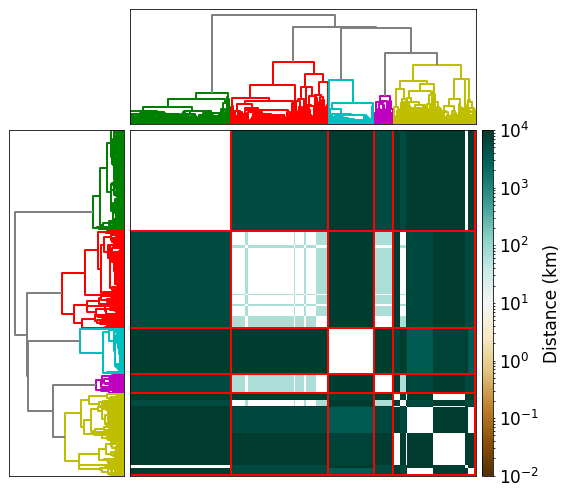

In [899]:
# Compute and plot first dendrogram.
fig = pylab.figure(figsize=(8,8))

ax1 = fig.add_axes([0.3,0.71,0.6,0.2])
dendro = scipy.cluster.hierarchy.dendrogram(
   linkage,
   color_threshold=6,
   above_threshold_color = 'grey',
    no_labels = True)
ax1.set_xticks([])
ax1.set_yticks([])

# Compute and plot second dendrogram.
ax2 = fig.add_axes([0.09,0.1,0.2,0.6])
dendro = scipy.cluster.hierarchy.dendrogram(
                        linkage,
                        color_threshold=6,
                        above_threshold_color = 'grey',
                        orientation = 'left',
                        no_labels = True, ax = ax2)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.invert_yaxis()

colors=np.array(dendro['color_list'])
borders = np.nonzero(colors[1:]!=colors[:-1])[0]

# Plot distance matrix.
axmatrix = fig.add_axes([0.3,0.1,0.6,0.6])
axmatrix.hlines(borders,0, geo_dist_matrix.shape[0], 'r')
axmatrix.vlines(borders,0, geo_dist_matrix.shape[0], 'r' )
im = axmatrix.matshow(geo_dist_matrix[ind2show, :][:, ind2show][dendro['leaves'],:][:, dendro['leaves']], 
                      cmap=cm.BrBG, norm=LogNorm(vmin=0.01, vmax=10000))
axmatrix.set_xticks([])
axmatrix.set_yticks([])

# Plot colorbar.
axcolor = fig.add_axes([0.91,0.1,0.02,0.6])
cbar = pylab.colorbar(im, cax=axcolor)
cbar.set_label('Distance (km)')
plt.savefig('../presentation/dendro.png', dpi = 300, bbox_inches = 'tight')

Looks like samples from the same location are also similar to each other in terms of OTU composition. **Add OTU abundances for samples from the same location**.

In [667]:
same_loc_ind = [i for i in map_file_soil.groupby(['pos']).indices.values()]
positions = list(map_file_soil.groupby(['pos']).groups.keys())
mat_condensed = np.array([mat_dense[ind].sum(axis = 0) for ind in same_loc_ind])

Combine mapping file accordingly.

In [945]:
map_file_combined = map_file_soil.groupby('pos', as_index=False).agg(lambda s: s[~s.isnull()].iloc[0])
map_file_combined.set_index('pos', inplace=True)
map_file_combined = map_file_combined.loc[positions]
otus_pos = map_file_soil.groupby('pos')['adiv_observed_otus'].sum()
map_file_combined.loc[otus_pos.index,'adiv_observed_otu'] = otus_pos.values

In [1419]:
map_file_combined.loc[
    map_file_combined.envo_biome_2 == 'anthropogenic terrestrial biome', 
                     'envo_biome_2'] = map_file_combined[
    map_file_combined.envo_biome_2 == 'anthropogenic terrestrial biome'].envo_biome_3

Calculate JSD distances for the new OTU table with combined abundances.

In [1177]:
dist_matrix_JSD_cond, mat_condensed_norm = calc_JSD(mat_condensed, 
                                  positions,
                                  save = False)

## Effect of low abundance species on the distance matrix

In [1595]:
cutoff = 1e-5

Make a table of OTU abundances.

In [1495]:
total_abundance = mat_condensed.sum(axis = 0)

OTU_abundance = pd.DataFrame({'total_abundance': total_abundance,
                             }, index = OTUs)
OTU_abundance['relative_abundance'] = 0
OTU_abundance.loc[OTU_abundance.total_abundance > 0,
                 'relative_abundance'] = OTU_abundance.loc[
                        OTU_abundance.total_abundance > 0,
                         'total_abundance']/OTU_abundance.total_abundance.sum()

Text(0,0.5,'Count')

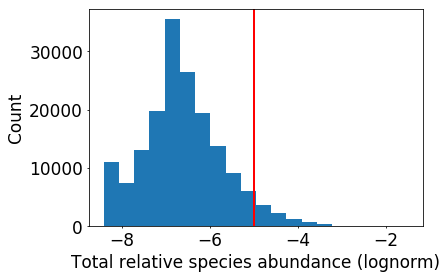

In [1599]:
_ = plt.hist(
    np.log10(OTU_abundance[OTU_abundance.relative_abundance > 0].relative_abundance),
    bins = 20)
plt.axvline(np.log10(cutoff), color = 'red')
plt.xlabel('Total relative species abundance (lognorm)')
plt.ylabel('Count')

Calculate the distance matrix after removing the species with abundance below the cutoff.

In [1596]:
dist_matrix_JSD_cond_high_abu, _ = calc_JSD(
                                  mat_condensed[:, OTU_abundance.relative_abundance > cutoff], 
                                  positions,
                                  save = False)

Plot correlation between pairwise distances calculated for the full table and the one with only species above the cutoff abundance.

Text(0.5,1,'JSD distance')

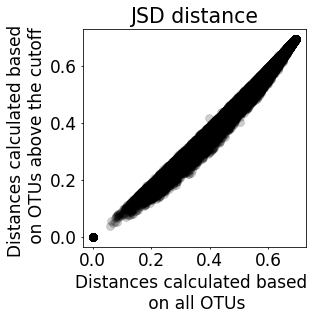

In [1597]:
plt.figure(figsize=(4,4))
plt.plot(
    dist_matrix_JSD_cond.flatten(), 
    dist_matrix_JSD_cond_high_abu.flatten(), 'ko', alpha = 0.1)
plt.xlabel('Distances calculated based \n on all OTUs')
plt.ylabel('Distances calculated based \n on OTUs above the cutoff')
plt.title('JSD distance')

Text(0.5,1,'Cosine distance')

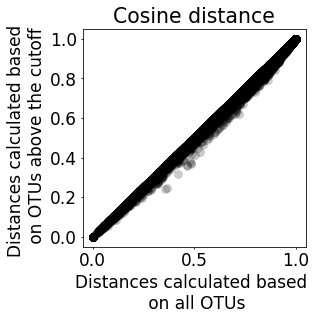

In [1598]:
plt.figure(figsize=(4,4))
plt.plot(
    sklearn.metrics.pairwise.pairwise_distances(
                                                mat_condensed, 
                                                metric = 'cosine',
                                                n_jobs = 1), 
    sklearn.metrics.pairwise.pairwise_distances(
                                                mat_condensed[:, OTU_abundance.relative_abundance > cutoff], 
                                                metric = 'cosine',
                                                n_jobs = 1),
    'ko', alpha = 0.1)
plt.xlabel('Distances calculated based \n on all OTUs')
plt.ylabel('Distances calculated based \n on OTUs above the cutoff')
plt.title('Cosine distance')

## Plot similarity vs distance

Construct a dataframe with similarity and geographical distance column for each sample.

In [906]:
geo_distances = geo_dist_matrix[np.triu_indices(geo_dist_matrix.shape[0], k=1)]
similarity = 1 - dist_matrix_JSD[np.triu_indices(dist_matrix_JSD.shape[0], k=1)]
dist_frame = pd.DataFrame({'geo_distance': geo_distances, 
                           'similarity': similarity, 
                           'sample1': samples[np.triu_indices(dist_matrix_JSD.shape[0], k=1)[0]], 
                           'sample2': samples[np.triu_indices(dist_matrix_JSD.shape[0], k=1)[1]]})

List of plotting parameters

In [931]:
params2plot = [{'parameter': 'empo_3', 
                'value': 'Soil (non-saline)', 
                'label': 'all', 'color': sns.xkcd_palette(['navy blue'])[0],
               'n_points': 300000, 'results': []},
              {'parameter': 'envo_biome_3', 
                'value': 'cropland biome', 
                'label': 'cropland', 'color': sns.xkcd_palette(['kelly green'])[0], 
               'n_points': 8000,'results': []},
              {'parameter': 'envo_biome_2', 
                'value': 'desert biome', 
                'label': 'desert', 'color': sns.xkcd_palette(['golden yellow'])[0], 
               'n_points': 2000,'results': []}]

Plot

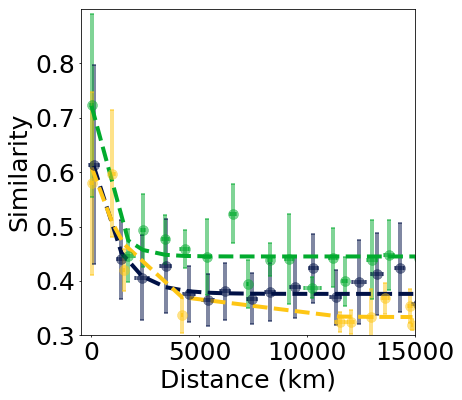

In [1604]:
fig = plt.figure(figsize=(3.*2,3*2))
init_plotting_style(markersize=10, tick_font_size=25,font_size=25, lw = 4)
ax = fig.add_subplot(111)

for i in range(len(params2plot)):
     
    if len(params2plot[i]['results']) == 0:
        _,dist_frame_grouped = group_by_param(params2plot[i]['parameter'], 
                                              params2plot[i]['value'],
                                               binby = 'dist')
        params2plot[i]['results'] = dist_frame_grouped
    
    plot_sim_vs_dist(ax, params2plot[i]['results'], 
                     params2plot[i]['color'], 
                     params2plot[i]['label'])
ax.legend(bbox_to_anchor = (-0., -0.,1,1),
           ncol=1)
ax.set_xlabel('Distance (km)')
ax.set_ylabel('Similarity')
ax.set_xlim(-500, 15000)
ax.set_ylim(0.3, 0.9)
_ = ax.set_yticks(np.arange(0.3, 0.85, 0.1))
_ = ax.set_xticks(np.arange(0, 16000, 5000))
plt.savefig('../presentation/sim_vs_dist.png', dpi = 300, bbox_inches = 'tight')

## Topic modelling

Find the optimal number of latent communities that describes the dataset.

In [1259]:
i = 0
no_topics = 10
perplexity = []
threshold = 0.01
tol = 1
perplexity_old = 1000
while tol > threshold:
    print('iteraion {0}, {1} topics'.format(i, no_topics))
    # Run LDA
    lda = sklearn.decomposition.LatentDirichletAllocation(n_topics=no_topics, 
                                    max_iter=5, 
                                    learning_method='online', 
                                    learning_offset=50.,
                                    random_state=0).fit(mat_condensed)
    perplexity.append({'no_topics': no_topics,
                      'perplexity': lda.perplexity(mat_condensed)})
    
    tol = abs(perplexity[i]['perplexity'] - perplexity_old)/perplexity_old
    perplexity_old = perplexity[i]['perplexity']
    i += 1
    no_topics += 5

iteraion 0, 10 topics
iteraion 1, 15 topics
iteraion 2, 20 topics
iteraion 3, 25 topics


Text(0,0.5,'Perplexity')

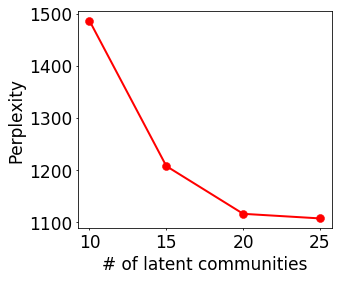

In [1260]:
plt.figure(figsize=(10, 4))
perplexity = pd.DataFrame(perplexity)
plt.subplot(121)
plt.plot(perplexity.no_topics, perplexity.perplexity, 'ro-')
plt.xlabel('# of latent communities')
plt.ylabel('Perplexity')

Transform the original matrix.

In [1266]:
lda = sklearn.decomposition.LatentDirichletAllocation(n_topics=20, 
                                max_iter=5, 
                                learning_method='batch', 
                                learning_offset=50.,random_state=0).fit(mat_condensed)
mat_condensed_lda = lda.transform(mat_condensed)

Calculate the distance matrix in the space of latent communities. 

In [1267]:
dist_matrix_JSD_cond_lda, mat_condensed_lda_norm = calc_JSD(mat_condensed_lda, 
                                                          positions,
                                                          save = False)

## Topic distribution between different environments

Get topic over samples info

In [1282]:
topic_dist = pd.DataFrame(mat_condensed_lda,
             index = positions, 
             columns = ['Topic{}'.format(i) 
                        for i in range(mat_condensed_lda.shape[1])], )

Combine topic and biome info

In [1420]:
topics_over_samples = pd.concat([map_file_combined['envo_biome_2'], topic_dist], axis=1)
topics_over_biomes = topics_over_samples.groupby('envo_biome_2').sum()

Select 20 random colors from the palette.

In [1408]:
palette = sns.xkcd_palette(
    colors.loc[np.array(random.sample(range(colors.shape[0]), 20)), 
               'color'].values)

Plot topics distribution over biomes.

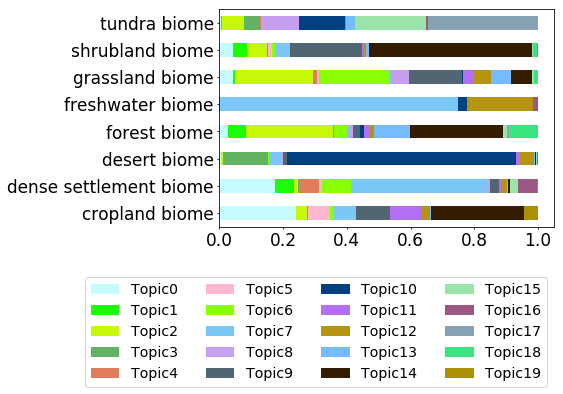

In [1602]:
topics_over_biomes.div(topics_over_biomes.sum(axis=1), 
                       axis = 'index').plot.barh(stacked=True,
                                               color=palette)
plt.legend(bbox_to_anchor = (0., -1.2,1,1),
           ncol=4)
plt.ylabel('')
plt.savefig('../presentation/topics_over_biomes.png',dpi = 300, bbox_inches = 'tight')

## Dimensionality reduction with MDS

Metric MDS

In [1250]:
seed = np.random.RandomState(seed=3)

mds = sklearn.manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=seed,
                   dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(dist_matrix_JSD_cond_lda).embedding_

non-Metric MDS

In [1251]:
nmds = sklearn.manifold.MDS(n_components=2, metric=False, max_iter=3000, eps=1e-12,
                    dissimilarity="precomputed", random_state=seed, n_jobs=1,
                    n_init=1)
npos = nmds.fit_transform(dist_matrix_JSD_cond_lda, init=pos)

Add mds parameters to the mapping file for each sample.

In [1252]:
map_file_combined.loc[np.array(positions), 'lda_mds_x'] = pos[:, 0]
map_file_combined.loc[np.array(positions), 'lda_mds_y'] = pos[:, 1]
map_file_combined.loc[np.array(positions), 'lda_nmds_x'] = npos[:, 0]
map_file_combined.loc[np.array(positions), 'lda_nmds_y'] = npos[:, 1]

## 2D embedding with t-SNE

Test several t-SNE models with different perplexity values ([Illustration](https://distill.pub/2016/misread-tsne/) of the effect that perplexity value has on the result).

In [1253]:
perplexities = [30, 35]
results = []
for i, perplexity in enumerate(perplexities):
    
    Y = sklearn.manifold.TSNE(n_components=2,
         perplexity = perplexity, 
         verbose = 1, metric = 'precomputed',
         n_iter = 2000).fit_transform(dist_matrix_JSD_cond_lda)
    results.append({'perplexity': perplexity,
                  'Y': Y})

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 403 samples in 0.000s...
[t-SNE] Computed neighbors for 403 samples in 0.009s...
[t-SNE] Computed conditional probabilities for sample 403 / 403
[t-SNE] Mean sigma: 0.208078
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.561741
[t-SNE] Error after 1250 iterations: 0.276094
[t-SNE] Computing 106 nearest neighbors...
[t-SNE] Indexed 403 samples in 0.000s...
[t-SNE] Computed neighbors for 403 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 403 / 403
[t-SNE] Mean sigma: 0.231558
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.050575
[t-SNE] Error after 1400 iterations: 0.283103


In [1254]:
map_file_combined.loc[np.array(positions), 'lda_t_SNE_x'] = results[0]['Y'][:, 0]
map_file_combined.loc[np.array(positions), 'lda_t_SNE_y'] = results[0]['Y'][:, 1]

Save new map file with t-SNE coordinates to file.

In [727]:
map_file_combined.reset_index(inplace=True)
map_file_combined.to_csv('../dash/data/emp_deblur_90bp.qc_filtered_soil.t-SNE_JSD.by_loc.csv')

## 2D visualization

Plot resulting models and color points by metadata.

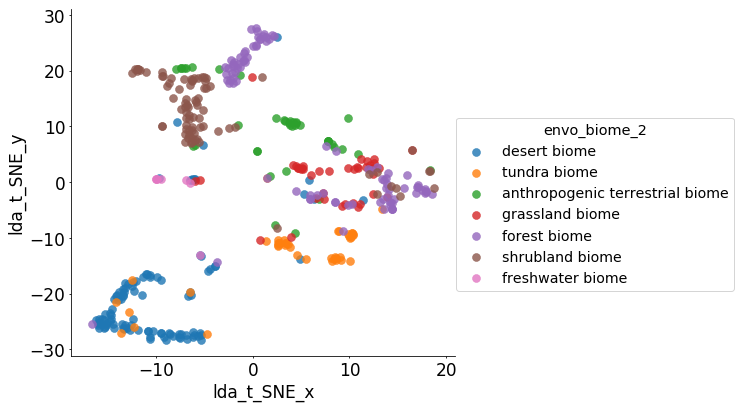

In [1257]:
sns.lmplot(x = 'lda_mds_x',
              y = 'lda_mds_y', data = map_file_combined,
             hue = 'envo_biome_2', fit_reg=False, size = 6, aspect = 1.2)

Save map file with topics, mds, and t-sne coordinates to csv

In [ ]:
pd.concat([map_file_combined, topic_dist], 
          axis=1).reset_index().to_csv(
    '../dash/data/emp_deblur_90bp.qc_filtered_soil.t-SNE_JSD_LDA_topics.by_loc.csv'
                                                    )